### Install & Import Dependencies

In [1]:
%pip install flappy-bird-gymnasium
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
from collections import defaultdict
import pickle
import gzip

import flappy_bird_gymnasium
import gymnasium

import matplotlib.pyplot as plt
from tqdm import tqdm

### Discretization

In [10]:
def create_uniform_grid(low, high, bins=(10, 10)):
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] for dim in range(len(bins))]
    return grid

def discretize(sample, grid):
    return list(int(np.digitize(s, g)) for s, g in zip(sample, grid))

### Q-Learning Agent

In [11]:
class QLearningAgent:
    def __init__(
        self,
        learning_rate: float = None,
        initial_epsilon: float = 0.0,
        epsilon_decay: float = None,
        final_epsilon: float = None,
        discount_factor: float = 0.95,
        env: gymnasium.Env = None,
        discretization_bin_size: int = 10_000,
    ):
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(self.env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_grid = create_uniform_grid(
            self.env.observation_space.low, 
            self.env.observation_space.high, 
            bins=tuple([discretization_bin_size] * self.env.observation_space.low.shape[0])
        )

    
    def preprocess_state(self, state):
        return tuple(discretize(state, self.state_grid))
        

    def get_action(self, obs):
        tuple_obs = self.preprocess_state(obs)
        observation_exists = tuple_obs in self.q_values

        if np.random.random() < self.epsilon or not observation_exists:
            return self.env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[tuple_obs]))

    def update(
        self,
        obs,
        action,
        reward,
        terminated,
        next_obs,
    ):
        next_obs_tuple = self.preprocess_state(next_obs)
        obs_tuple = self.preprocess_state(obs)
        future_q_value = (not terminated) * np.max(self.q_values[next_obs_tuple])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs_tuple][action]
        )

        self.q_values[obs_tuple][action] = (
            self.q_values[obs_tuple][action] + self.lr * temporal_difference
        )

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(dict(self.q_values), f)

    def load(self, path):
        with open(path, 'rb') as f:
            self.q_values = defaultdict(lambda: np.zeros(self.env.action_space.n), pickle.load(f))

### Helper Functions

In [12]:
def transform_reward(reward):
    mapping = {
        0.1: 0, # reward for 1 second of survival
        1.0: 15, # reward for passing a pipe
        -1.0: -1000, # reward for dying/reaching the ground
        -0.5: -5, # reward for hitting a ceiling
    }
    return mapping[reward]

In [42]:
def plot_charts(
    env: gymnasium.Env, agent: QLearningAgent, rolling_length: int = 500, count_scores: dict = {}, title: str = None
):
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

    try:
        axs[0].set_title("Episode rewards")
        reward_moving_average = (
            np.convolve(
                np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
    except:
        pass

    try:
        axs[1].set_title("Episode lengths")
        length_moving_average = (
            np.convolve(
                np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
            )
            / rolling_length
        )
        axs[1].plot(range(len(length_moving_average)), length_moving_average)
    except:
        pass

    try:
        axs[2].set_title("Scores")
        sorted_scores = dict(sorted(count_scores.items()))
        axs[2].bar(sorted_scores.keys(), sorted_scores.values())
        for i, v in count_scores.items():
            axs[2].text(i, v + 0.1, str(v), ha="center", va="bottom")
    except:
        pass

    
    if title:
        fig.suptitle(title)
        
    plt.tight_layout()
    plt.show()

### Training

In [86]:
def test_agent(agent, episodes=10, render_mode=None):
    env = gymnasium.make("FlappyBird-v0", render_mode=render_mode, use_lidar=False)
    env = gymnasium.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)
    env = gymnasium.wrappers.TransformReward(env, transform_reward)


    count_scores = {}
    for _ in range(episodes):
        obs, info = env.reset()
        done = False
        while not done:
            action = agent.get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        score = info["score"]
        count_scores[score] = count_scores.get(score, 0) + 1
    return env, count_scores

In [92]:
def train(
    learning_rate,
    start_epsilon,
    final_epsilon,
    n_episodes,
    discretization_bin_size,
    save_path=None,
    load_path=None,
):
    print(
        f"\n\n#################################",
        f"Learning rate: {learning_rate}",
        f"Start epsilon: {start_epsilon}",
        f"Final epsilon: {final_epsilon}",
        f"Number of episodes: {n_episodes}",
        f"Discretization bin size: {discretization_bin_size}",
        f"Save path: {save_path}",
        f"Load path: {load_path}",
        "------------------------------------",
        sep="\n",
    )
    epsilon_decay = start_epsilon / (n_episodes / 2)

    env = gymnasium.make("FlappyBird-v0", use_lidar=False)
    env = gymnasium.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    env = gymnasium.wrappers.TransformReward(env, transform_reward)

    agent = QLearningAgent(
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        env=env,
        discretization_bin_size=discretization_bin_size,
    )

    if load_path:
        agent.load(load_path)
    

    count_scores = defaultdict(int)
    local_count_scores = defaultdict(int)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated
            agent.update(obs, action, reward, done, next_obs)

            obs = next_obs

        agent.decay_epsilon()

        # store the score of the episode
        score = info["score"]
        count_scores[score] += 1
        local_count_scores[score] += 1

        if episode % 5_000 == 0:
            percentage_count = {k: f"{(100 * v / sum(count_scores.values())):.5f}%" for k, v in count_scores.items()}
            sorted_by_key = dict(sorted(percentage_count.items()))
            local_sorted_by_key = dict(sorted(local_count_scores.items()))
            print(
                f"Episode {episode}", 
                f"Running Scores Percentage: {sorted_by_key}",
                f"Local Scores Count: {local_sorted_by_key}",
                sep="\n"
            )
            local_count_scores = defaultdict(int)

    agent.save(save_path)

    plot_charts(env, agent, count_scores=count_scores, title="Training results")

    # Test the agent on 1000 episodes and plot the results
    env, count_scores = test_agent(agent, episodes=1000)
    plot_charts(env, agent, count_scores=count_scores, title="Test results")

In [93]:
configs = [
    {
        "learning_rate": 0.01,
        "start_epsilon": 1.0,
        "final_epsilon": 0.1,
        "n_episodes": 500_000,
        "discretization_bin_size": 100,
        "save_path": "discretized/lr-0.01-eps-1.0-0.1-episodes-500k-bins-100.pkl",
        "load_path": None,
    },
    {
        "learning_rate": 0.001,
        "start_epsilon": 0.1,
        "final_epsilon": 0.01,
        "n_episodes": 200_000,
        "discretization_bin_size": 100,
        "save_path": "discretized/lr-0.001-eps-0.1-0.01-episodes-200k-bins-100.pkl",
        "load_path": "discretized/lr-0.01-eps-1.0-0.1-episodes-500k-bins-100.pkl",
    },
    {
        "learning_rate": 0.001,
        "start_epsilon": 0.1,
        "final_epsilon": 0.01,
        "n_episodes": 100_000,
        "discretization_bin_size": 100,
        "save_path": "discretized/lr-0.001-eps-0.1-0.01-episodes-100k-bins-100.pkl",
        "load_path": "discretized/lr-0.001-eps-0.1-0.01-episodes-200k-bins-100.pkl",
    },

    {
        "learning_rate": 0.01,
        "start_epsilon": 1.0,
        "final_epsilon": 0.1,
        "n_episodes": 500_000,
        "discretization_bin_size": 10,
        "save_path": "discretized/lr-0.01-eps-1.0-0.1-episodes-500k-bins-10.pkl",
        "load_path": None,
    },
    {
        "learning_rate": 0.001,
        "start_epsilon": 0.1,
        "final_epsilon": 0.01,
        "n_episodes": 500_000,
        "discretization_bin_size": 10,
        "save_path": "discretized/lr-0.001-eps-0.1-0.01-episodes-500k-bins-10.pkl",
        "load_path": "discretized/lr-0.01-eps-1.0-0.1-episodes-500k-bins-10.pkl",
    },    
    {
        "learning_rate": 0.001,
        "start_epsilon": 0.01,
        "final_epsilon": 0.001,
        "n_episodes": 500_000,
        "discretization_bin_size": 10,
        "save_path": "discretized/lr-0.001-eps-0.01-0.001-episodes-500k-bins-10.pkl",
        "load_path": "discretized/lr-0.001-eps-0.1-0.01-episodes-500k-bins-10.pkl",
    },
]



#################################
Learning rate: 0.001
Start epsilon: 0.1
Final epsilon: 0.01
Number of episodes: 200000
Discretization bin size: 100
Save path: discretized/lr-0.001-eps-0.1-0.01-episodes-200k-bins-100.pkl
Load path: discretized/lr-0.01-eps-1.0-0.1-episodes-500k-bins-100.pkl
------------------------------------


  0%|          | 18/200000 [00:00<19:13, 173.35it/s]

Episode 0
Running Scores Percentage: {1: '100.00000%'}
Local Scores Count: {1: 1}


 25%|██▌       | 50020/200000 [05:09<19:10, 130.39it/s]

Episode 50000
Running Scores Percentage: {0: '43.04514%', 1: '41.30917%', 2: '14.41971%', 3: '1.10998%', 4: '0.09400%', 5: '0.02000%', 6: '0.00200%'}
Local Scores Count: {0: 21523, 1: 20654, 2: 7210, 3: 555, 4: 47, 5: 10, 6: 1}


 50%|█████     | 100020/200000 [12:05<15:53, 104.80it/s]

Episode 100000
Running Scores Percentage: {0: '30.67369%', 1: '37.85062%', 2: '24.87175%', 3: '5.41295%', 4: '0.69599%', 5: '0.43200%', 6: '0.05400%', 7: '0.00300%', 8: '0.00600%'}
Local Scores Count: {0: 9151, 1: 17196, 2: 17662, 3: 4858, 4: 649, 5: 422, 6: 53, 7: 3, 8: 6}


 75%|███████▌  | 150011/200000 [20:21<07:36, 109.39it/s]

Episode 150000
Running Scores Percentage: {0: '24.72184%', 1: '33.35378%', 2: '28.83447%', 3: '10.16593%', 4: '1.44466%', 5: '1.21199%', 6: '0.21333%', 7: '0.02467%', 8: '0.02333%', 9: '0.00600%'}
Local Scores Count: {0: 6409, 1: 12180, 2: 18380, 3: 9836, 4: 1471, 5: 1386, 6: 266, 7: 34, 8: 29, 9: 9}


100%|██████████| 200000/200000 [28:31<00:00, 116.84it/s]
/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.return_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.return_queue` for environment variables or `env.get_wrapper_attr('return_queue')` that will search the reminding wrappers.
  logger.warn(
/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.length_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.length_queue` for environment variables or `env.get_wrapper_attr('length_queue')` that will search the reminding wrappers.
  logger.warn(


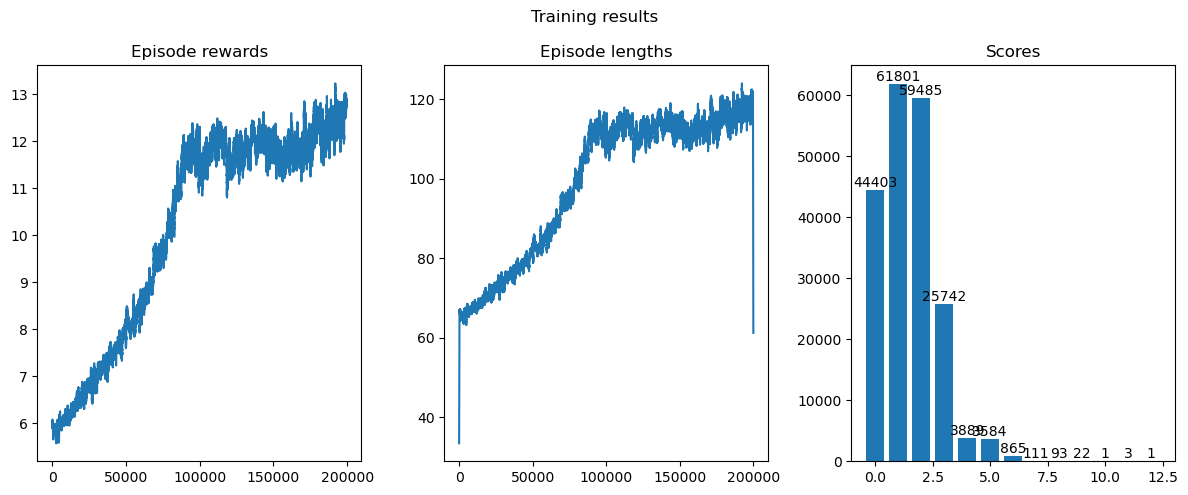

/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


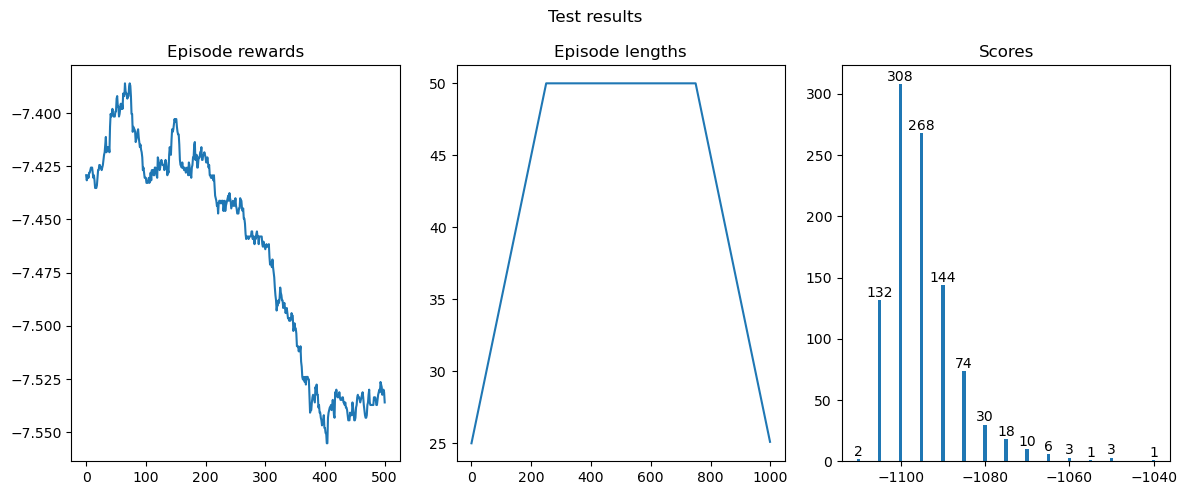

In [74]:
train(**configs[1])



#################################
Learning rate: 0.001
Start epsilon: 0.1
Final epsilon: 0.01
Number of episodes: 100000
Discretization bin size: 100
Save path: discretized/lr-0.001-eps-0.1-0.01-episodes-100k-bins-100.pkl
Load path: discretized/lr-0.001-eps-0.1-0.01-episodes-200k-bins-100.pkl
------------------------------------


  0%|          | 34/100000 [00:00<10:07, 164.51it/s]

Episode 0
Running Scores Percentage: {1: '100.00000%'}
Local Scores Count: {1: 1}


  5%|▌         | 5021/100000 [00:29<09:23, 168.47it/s]

Episode 5000
Running Scores Percentage: {0: '53.14937%', 1: '35.09298%', 2: '9.79804%', 3: '1.69966%', 4: '0.17996%', 5: '0.07998%'}
Local Scores Count: {0: 2658, 1: 1754, 2: 490, 3: 85, 4: 9, 5: 4}


 10%|█         | 10025/100000 [00:59<08:58, 167.16it/s]

Episode 10000
Running Scores Percentage: {0: '50.25497%', 1: '36.24638%', 2: '11.16888%', 3: '2.01980%', 4: '0.22998%', 5: '0.06999%', 6: '0.01000%'}
Local Scores Count: {0: 2368, 1: 1870, 2: 627, 3: 117, 4: 14, 5: 3, 6: 1}


 15%|█▌        | 15020/100000 [01:30<09:01, 156.90it/s]

Episode 15000
Running Scores Percentage: {0: '47.94347%', 1: '37.10419%', 2: '12.25252%', 3: '2.33984%', 4: '0.27998%', 5: '0.07333%', 6: '0.00667%'}
Local Scores Count: {0: 2166, 1: 1941, 2: 721, 3: 149, 4: 19, 5: 4}


 20%|██        | 20015/100000 [02:03<09:04, 146.78it/s]

Episode 20000
Running Scores Percentage: {0: '45.85271%', 1: '37.33813%', 2: '13.60932%', 3: '2.71486%', 4: '0.38998%', 5: '0.08500%', 6: '0.01000%'}
Local Scores Count: {0: 1979, 1: 1902, 2: 884, 3: 192, 4: 36, 5: 6, 6: 1}


 25%|██▌       | 25018/100000 [02:37<08:46, 142.32it/s]

Episode 25000
Running Scores Percentage: {0: '43.57026%', 1: '37.77449%', 2: '14.87540%', 3: '3.13987%', 4: '0.49598%', 5: '0.12000%', 6: '0.02000%', 7: '0.00400%'}
Local Scores Count: {0: 1722, 1: 1976, 2: 997, 3: 242, 4: 46, 5: 13, 6: 3, 7: 1}


 30%|███       | 30016/100000 [03:14<08:40, 134.58it/s]

Episode 30000
Running Scores Percentage: {0: '40.85864%', 1: '37.94874%', 2: '16.38945%', 3: '3.94320%', 4: '0.63998%', 5: '0.16999%', 6: '0.04667%', 7: '0.00333%'}
Local Scores Count: {0: 1365, 1: 1941, 2: 1198, 3: 398, 4: 68, 5: 21, 6: 9}


 35%|███▌      | 35015/100000 [03:53<08:46, 123.45it/s]

Episode 35000
Running Scores Percentage: {0: '38.47319%', 1: '37.52464%', 2: '17.89663%', 3: '4.88843%', 4: '0.83998%', 5: '0.28856%', 6: '0.08285%', 7: '0.00571%'}
Local Scores Count: {0: 1208, 1: 1749, 2: 1347, 3: 528, 4: 102, 5: 50, 6: 15, 7: 1}


 40%|████      | 40019/100000 [04:35<08:26, 118.40it/s]

Episode 40000
Running Scores Percentage: {0: '36.04160%', 1: '36.81158%', 2: '19.43701%', 3: '6.04735%', 4: '1.03247%', 5: '0.46499%', 6: '0.13750%', 7: '0.01250%', 8: '0.01000%', 9: '0.00500%'}
Local Scores Count: {0: 951, 1: 1591, 2: 1511, 3: 708, 4: 119, 5: 85, 6: 26, 7: 3, 8: 4, 9: 2}


 45%|████▌     | 45019/100000 [05:23<08:46, 104.34it/s]

Episode 45000
Running Scores Percentage: {0: '34.16369%', 1: '35.31699%', 2: '20.69065%', 3: '7.47539%', 4: '1.33775%', 5: '0.68887%', 6: '0.26222%', 7: '0.02667%', 8: '0.02444%', 9: '0.01333%'}
Local Scores Count: {0: 957, 1: 1168, 2: 1536, 3: 945, 4: 189, 5: 124, 6: 63, 7: 7, 8: 7, 9: 4}


 50%|█████     | 50017/100000 [06:13<08:42, 95.70it/s] 

Episode 50000
Running Scores Percentage: {0: '32.39135%', 1: '33.71733%', 2: '21.44157%', 3: '9.25781%', 4: '1.58597%', 5: '1.09598%', 6: '0.40599%', 7: '0.03200%', 8: '0.04600%', 9: '0.02200%', 10: '0.00400%'}
Local Scores Count: {0: 822, 1: 966, 2: 1410, 3: 1265, 4: 191, 5: 238, 6: 85, 7: 4, 8: 12, 9: 5, 10: 2}


 55%|█████▌    | 55013/100000 [07:03<07:14, 103.63it/s]

Episode 55000
Running Scores Percentage: {0: '30.83762%', 1: '32.50305%', 2: '21.94142%', 3: '10.77253%', 4: '1.80542%', 5: '1.41816%', 6: '0.58544%', 7: '0.04364%', 8: '0.05818%', 9: '0.02909%', 10: '0.00545%'}
Local Scores Count: {0: 765, 1: 1018, 2: 1347, 3: 1296, 4: 200, 5: 232, 6: 119, 7: 8, 8: 9, 9: 5, 10: 1}


 60%|██████    | 60016/100000 [07:55<07:14, 91.97it/s] 

Episode 60000
Running Scores Percentage: {0: '29.37284%', 1: '31.33114%', 2: '22.59296%', 3: '12.05980%', 4: '2.04830%', 5: '1.71830%', 6: '0.69499%', 7: '0.06167%', 8: '0.07167%', 9: '0.04333%', 10: '0.00500%'}
Local Scores Count: {0: 663, 1: 922, 2: 1488, 3: 1311, 4: 236, 5: 251, 6: 95, 7: 13, 8: 11, 9: 10}


 65%|██████▌   | 65014/100000 [08:48<06:42, 86.82it/s] 

Episode 65000
Running Scores Percentage: {0: '28.12572%', 1: '30.33184%', 2: '23.08888%', 3: '13.25980%', 4: '2.19689%', 5: '1.96151%', 6: '0.80768%', 7: '0.07077%', 8: '0.10308%', 9: '0.04769%', 10: '0.00462%', 12: '0.00154%'}
Local Scores Count: {0: 658, 1: 917, 2: 1452, 3: 1383, 4: 199, 5: 244, 6: 108, 7: 9, 8: 24, 9: 5, 12: 1}


 70%|███████   | 70019/100000 [09:41<05:23, 92.72it/s] 

Episode 70000
Running Scores Percentage: {0: '27.10818%', 1: '29.32387%', 2: '23.62823%', 3: '14.20408%', 4: '2.33140%', 5: '2.20140%', 6: '0.93856%', 7: '0.07857%', 8: '0.11571%', 9: '0.06286%', 10: '0.00429%', 12: '0.00143%', 13: '0.00143%'}
Local Scores Count: {0: 694, 1: 811, 2: 1532, 3: 1324, 4: 204, 5: 266, 6: 132, 7: 9, 8: 14, 9: 13, 13: 1}


 75%|███████▌  | 75012/100000 [10:33<04:10, 99.60it/s] 

Episode 75000
Running Scores Percentage: {0: '26.41298%', 1: '28.41295%', 2: '23.90501%', 3: '15.02113%', 4: '2.47463%', 5: '2.39063%', 6: '1.08265%', 7: '0.09333%', 8: '0.12666%', 9: '0.07067%', 10: '0.00667%', 12: '0.00133%', 13: '0.00133%'}
Local Scores Count: {0: 834, 1: 783, 2: 1389, 3: 1323, 4: 224, 5: 252, 6: 155, 7: 15, 8: 14, 9: 9, 10: 2}


 80%|████████  | 80014/100000 [11:26<03:28, 95.68it/s] 

Episode 80000
Running Scores Percentage: {0: '25.81843%', 1: '27.65090%', 2: '24.05720%', 3: '15.83230%', 4: '2.56372%', 5: '2.54997%', 6: '1.17374%', 7: '0.11500%', 8: '0.14750%', 9: '0.07375%', 10: '0.00750%', 11: '0.00500%', 12: '0.00375%', 13: '0.00125%'}
Local Scores Count: {0: 845, 1: 811, 2: 1317, 3: 1400, 4: 195, 5: 247, 6: 127, 7: 22, 8: 23, 9: 6, 10: 1, 11: 4, 12: 2}


 85%|████████▌ | 85012/100000 [12:19<02:33, 97.36it/s] 

Episode 85000
Running Scores Percentage: {0: '25.25382%', 1: '26.94909%', 2: '24.24795%', 3: '16.56216%', 4: '2.64938%', 5: '2.69762%', 6: '1.26351%', 7: '0.12353%', 8: '0.16117%', 9: '0.07294%', 10: '0.00706%', 11: '0.00471%', 12: '0.00588%', 13: '0.00118%'}
Local Scores Count: {0: 811, 1: 786, 2: 1365, 3: 1412, 4: 201, 5: 253, 6: 135, 7: 13, 8: 19, 9: 3, 12: 2}


 90%|█████████ | 90017/100000 [13:13<01:52, 89.06it/s] 

Episode 90000
Running Scores Percentage: {0: '24.72417%', 1: '26.30082%', 2: '24.39973%', 3: '17.23648%', 4: '2.72330%', 5: '2.83775%', 6: '1.36443%', 7: '0.13667%', 8: '0.17666%', 9: '0.08000%', 10: '0.00778%', 11: '0.00556%', 12: '0.00556%', 13: '0.00111%'}
Local Scores Count: {0: 786, 1: 764, 2: 1349, 3: 1435, 4: 199, 5: 261, 6: 154, 7: 18, 8: 22, 9: 10, 10: 1, 11: 1}


 95%|█████████▌| 95018/100000 [14:07<00:50, 98.51it/s] 

Episode 95000
Running Scores Percentage: {0: '24.27764%', 1: '25.71868%', 2: '24.51237%', 3: '17.80929%', 4: '2.81155%', 5: '2.95786%', 6: '1.45893%', 7: '0.15052%', 8: '0.17789%', 9: '0.10105%', 10: '0.00737%', 11: '0.00737%', 12: '0.00632%', 13: '0.00211%', 15: '0.00105%'}
Local Scores Count: {0: 812, 1: 762, 2: 1327, 3: 1406, 4: 220, 5: 256, 6: 158, 7: 20, 8: 10, 9: 24, 11: 2, 12: 1, 13: 1, 15: 1}


100%|██████████| 100000/100000 [15:00<00:00, 111.05it/s]
/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.return_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.return_queue` for environment variables or `env.get_wrapper_attr('return_queue')` that will search the reminding wrappers.
  logger.warn(
/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.length_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.length_queue` for environment variables or `env.get_wrapper_attr('length_queue')` that will search the reminding wrappers.
  logger.warn(


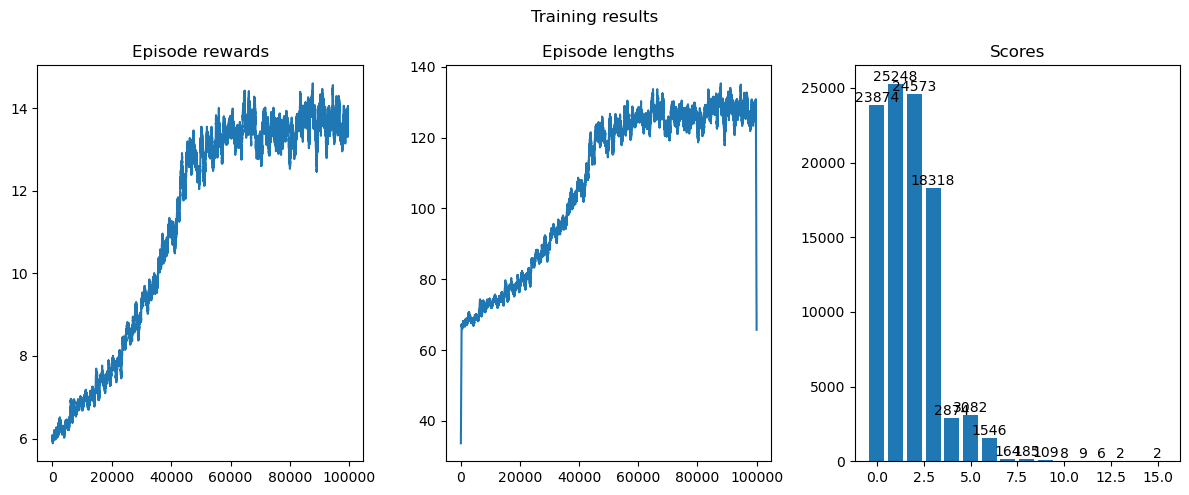

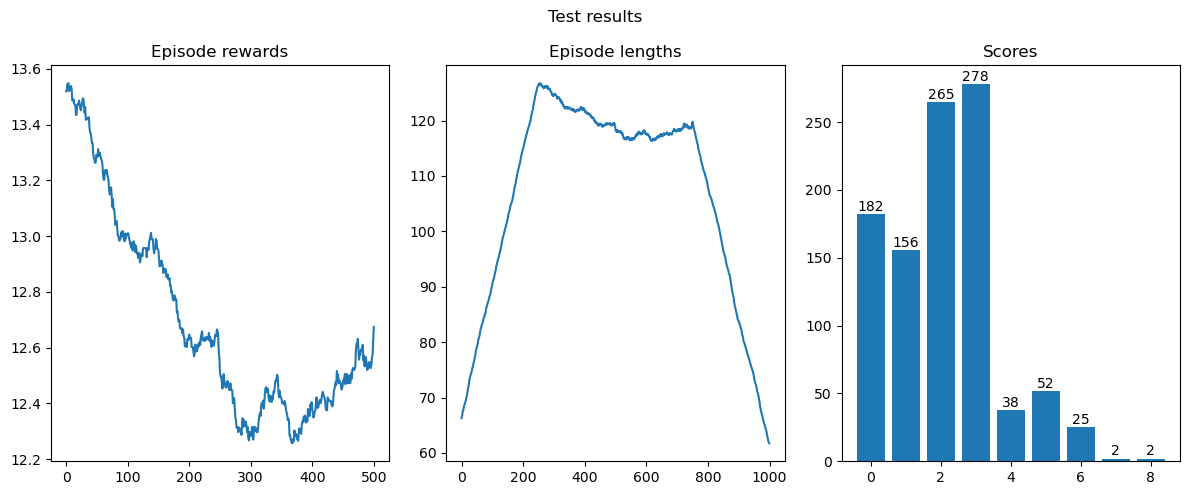

In [94]:
train(**configs[2])

### Testing

In [101]:
n_episodes = 30

env = gymnasium.make("FlappyBird-v0", use_lidar=False)
env = gymnasium.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
env = gymnasium.wrappers.TransformReward(env, transform_reward)

agent = QLearningAgent(
    env=env,
    discretization_bin_size=100,
)

agent.load("discretized/lr-0.001-eps-0.1-0.01-episodes-100k-bins-100.pkl")
env, count_scores = test_agent(agent, episodes=n_episodes, render_mode="human")

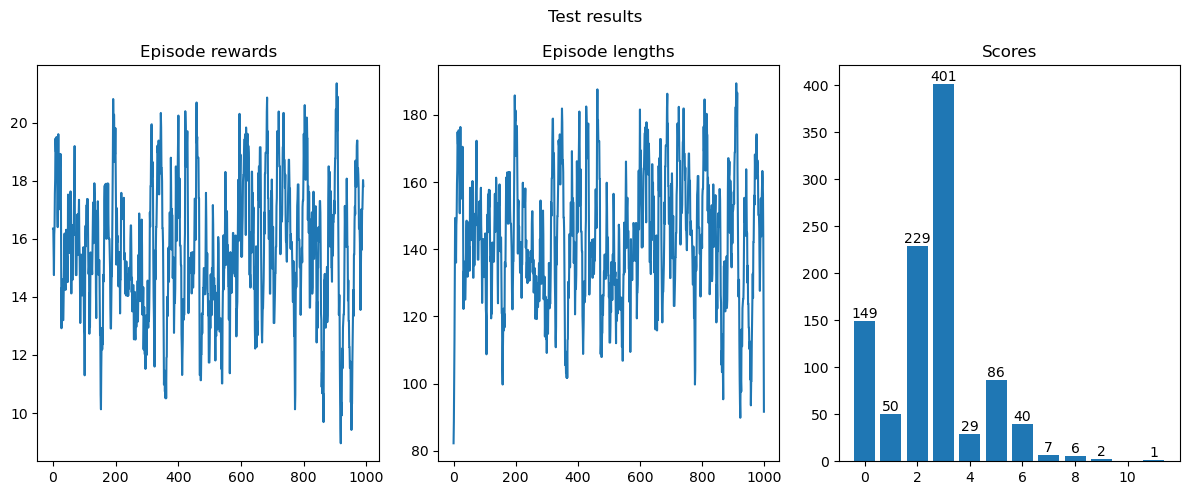

In [98]:
n_episodes = 1000

env = gymnasium.make("FlappyBird-v0", use_lidar=False)
env = gymnasium.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
env = gymnasium.wrappers.TransformReward(env, transform_reward)

agent = QLearningAgent(
    env=env,
    discretization_bin_size=100,
)

agent.load("discretized/lr-0.001-eps-0.1-0.01-episodes-100k-bins-100.pkl")

env, count_scores = test_agent(agent, episodes=n_episodes, render_mode=None)
plot_charts(env, agent, count_scores=count_scores, title="Test results", rolling_length=10)